In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 512)               471552    


 dense_1 (Dense)             (None, 256)               131328    


 dense_2 (Dense)             (None, 128)               32896     


 dense_3 (Dense)             (None, 1)                 129       


Total params: 635905 (2.43 MB)


Trainable params: 635905 (2.43 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:09 - loss: 0.0485 - STD: 0.0013 - MAE: 0.2033

 5/74 [=>............................] - ETA: 0s - loss: 0.0235 - STD: 0.0016 - MAE: 0.1212  

 8/74 [==>...........................] - ETA: 1s - loss: 0.0236 - STD: 0.0014 - MAE: 0.1219

11/74 [===>..........................] - ETA: 1s - loss: 0.0219 - STD: 0.0014 - MAE: 0.1155

14/74 [====>.........................] - ETA: 1s - loss: 0.0193 - STD: 0.0014 - MAE: 0.1072

17/74 [=====>........................] - ETA: 1s - loss: 0.0181 - STD: 0.0016 - MAE: 0.1051

20/74 [=======>......................] - ETA: 0s - loss: 0.0171 - STD: 0.0017 - MAE: 0.1029

23/74 [========>.....................] - ETA: 0s - loss: 0.0161 - STD: 0.0018 - MAE: 0.0992

26/74 [=========>....................] - ETA: 0s - loss: 0.0154 - STD: 0.0018 - MAE: 0.0964

29/74 [==========>...................] - ETA: 0s - loss: 0.0149 - STD: 0.0019 - MAE: 0.0941

32/74 [===========>..................] - ETA: 0s - loss: 0.0144 - STD: 0.0019 - MAE: 0.0922

35/74 [=============>................] - ETA: 0s - loss: 0.0139 - STD: 0.0021 - MAE: 0.0910

38/74 [==============>...............] - ETA: 0s - loss: 0.0136 - STD: 0.0022 - MAE: 0.0903

41/74 [===============>..............] - ETA: 0s - loss: 0.0133 - STD: 0.0023 - MAE: 0.0893

44/74 [================>.............] - ETA: 0s - loss: 0.0130 - STD: 0.0024 - MAE: 0.0881

47/74 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 0.0026 - MAE: 0.0871

50/74 [===================>..........] - ETA: 0s - loss: 0.0125 - STD: 0.0027 - MAE: 0.0863

53/74 [====================>.........] - ETA: 0s - loss: 0.0123 - STD: 0.0029 - MAE: 0.0856

56/74 [=====================>........] - ETA: 0s - loss: 0.0121 - STD: 0.0031 - MAE: 0.0851

59/74 [======================>.......] - ETA: 0s - loss: 0.0119 - STD: 0.0033 - MAE: 0.0845

62/74 [========================>.....] - ETA: 0s - loss: 0.0118 - STD: 0.0035 - MAE: 0.0839

65/74 [=========================>....] - ETA: 0s - loss: 0.0116 - STD: 0.0037 - MAE: 0.0834

66/74 [=========================>....] - ETA: 0s - loss: 0.0116 - STD: 0.0038 - MAE: 0.0832

71/74 [===========================>..] - ETA: 0s - loss: 0.0114 - STD: 0.0043 - MAE: 0.0824

74/74 [==============================] - ETA: 0s - loss: 0.0112 - STD: 0.0046 - MAE: 0.0820

74/74 [==============================] - 3s 34ms/step - loss: 0.0112 - STD: 0.0046 - MAE: 0.0820 - val_loss: 0.0076 - val_STD: 0.0088 - val_MAE: 0.0677


Epoch 2/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0082 - STD: 0.0134 - MAE: 0.0720

 4/74 [>.............................] - ETA: 1s - loss: 0.0083 - STD: 0.0141 - MAE: 0.0718

 7/74 [=>............................] - ETA: 1s - loss: 0.0081 - STD: 0.0150 - MAE: 0.0711

10/74 [===>..........................] - ETA: 1s - loss: 0.0080 - STD: 0.0160 - MAE: 0.0709

13/74 [====>.........................] - ETA: 1s - loss: 0.0080 - STD: 0.0170 - MAE: 0.0708

16/74 [=====>........................] - ETA: 1s - loss: 0.0079 - STD: 0.0180 - MAE: 0.0705

19/74 [======>.......................] - ETA: 1s - loss: 0.0079 - STD: 0.0190 - MAE: 0.0702

22/74 [=======>......................] - ETA: 1s - loss: 0.0078 - STD: 0.0201 - MAE: 0.0700

25/74 [=========>....................] - ETA: 1s - loss: 0.0078 - STD: 0.0213 - MAE: 0.0697

28/74 [==========>...................] - ETA: 0s - loss: 0.0077 - STD: 0.0224 - MAE: 0.0696

31/74 [===========>..................] - ETA: 0s - loss: 0.0077 - STD: 0.0235 - MAE: 0.0693

35/74 [=============>................] - ETA: 0s - loss: 0.0076 - STD: 0.0250 - MAE: 0.0690

38/74 [==============>...............] - ETA: 0s - loss: 0.0076 - STD: 0.0261 - MAE: 0.0687

41/74 [===============>..............] - ETA: 0s - loss: 0.0075 - STD: 0.0271 - MAE: 0.0685

44/74 [================>.............] - ETA: 0s - loss: 0.0075 - STD: 0.0281 - MAE: 0.0683

47/74 [==================>...........] - ETA: 0s - loss: 0.0074 - STD: 0.0290 - MAE: 0.0681

50/74 [===================>..........] - ETA: 0s - loss: 0.0074 - STD: 0.0298 - MAE: 0.0678

53/74 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.0306 - MAE: 0.0677

56/74 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0314 - MAE: 0.0674

59/74 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.0321 - MAE: 0.0673

62/74 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0327 - MAE: 0.0670

65/74 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0333 - MAE: 0.0668

68/74 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0339 - MAE: 0.0666

71/74 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.0344 - MAE: 0.0665

74/74 [==============================] - ETA: 0s - loss: 0.0071 - STD: 0.0349 - MAE: 0.0663

74/74 [==============================] - 2s 24ms/step - loss: 0.0071 - STD: 0.0349 - MAE: 0.0663 - val_loss: 0.0054 - val_STD: 0.0317 - val_MAE: 0.0569


Epoch 3/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0475 - MAE: 0.0610

 4/74 [>.............................] - ETA: 1s - loss: 0.0062 - STD: 0.0479 - MAE: 0.0614

 7/74 [=>............................] - ETA: 1s - loss: 0.0062 - STD: 0.0484 - MAE: 0.0614

10/74 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0486 - MAE: 0.0611

13/74 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0490 - MAE: 0.0610

16/74 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0492 - MAE: 0.0610

19/74 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0495 - MAE: 0.0609

22/74 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0500 - MAE: 0.0609

25/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0502 - MAE: 0.0607

28/74 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0506 - MAE: 0.0606

31/74 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0508 - MAE: 0.0604

34/74 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0510 - MAE: 0.0604

37/74 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0512 - MAE: 0.0602

40/74 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0514 - MAE: 0.0601

43/74 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0516 - MAE: 0.0599

46/74 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0518 - MAE: 0.0598

49/74 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0520 - MAE: 0.0596

52/74 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0521 - MAE: 0.0595

55/74 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0523 - MAE: 0.0594

58/74 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0526 - MAE: 0.0592

61/74 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0528 - MAE: 0.0591

64/74 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0530 - MAE: 0.0590

67/74 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0532 - MAE: 0.0588

71/74 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0535 - MAE: 0.0587

74/74 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0537 - MAE: 0.0585

74/74 [==============================] - 2s 24ms/step - loss: 0.0057 - STD: 0.0537 - MAE: 0.0585 - val_loss: 0.0043 - val_STD: 0.0450 - val_MAE: 0.0505


Epoch 4/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0594 - MAE: 0.0553

 3/74 [>.............................] - ETA: 1s - loss: 0.0052 - STD: 0.0602 - MAE: 0.0556

 6/74 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0605 - MAE: 0.0553

 9/74 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0607 - MAE: 0.0554

12/74 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0610 - MAE: 0.0553

16/74 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0612 - MAE: 0.0552

19/74 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0615 - MAE: 0.0550

22/74 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0617 - MAE: 0.0550

25/74 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0618 - MAE: 0.0549

28/74 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0619 - MAE: 0.0547

31/74 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0621 - MAE: 0.0547

34/74 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0621 - MAE: 0.0546

37/74 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0622 - MAE: 0.0546

40/74 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0622 - MAE: 0.0545

43/74 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0623 - MAE: 0.0545

46/74 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0624 - MAE: 0.0544

49/74 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0625 - MAE: 0.0544

52/74 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0626 - MAE: 0.0543

55/74 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0626 - MAE: 0.0543

58/74 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0627 - MAE: 0.0543

61/74 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0627 - MAE: 0.0542

64/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0628 - MAE: 0.0542

67/74 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0629 - MAE: 0.0541

70/74 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0630 - MAE: 0.0541

73/74 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0630 - MAE: 0.0540

74/74 [==============================] - 2s 24ms/step - loss: 0.0050 - STD: 0.0630 - MAE: 0.0540 - val_loss: 0.0040 - val_STD: 0.0488 - val_MAE: 0.0479


Epoch 5/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0636 - MAE: 0.0531

 3/74 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0528

 6/74 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0527

 9/74 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0646 - MAE: 0.0526

11/74 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0525

14/74 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0527

17/74 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0527

20/74 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0648 - MAE: 0.0528

23/74 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0528

26/74 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0527

29/74 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0527

32/74 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0527

35/74 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0527

39/74 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0528

42/74 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0528

44/74 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0528

48/74 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0528

51/74 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0528

54/74 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0527

57/74 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0527

60/74 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0651 - MAE: 0.0527

63/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0652 - MAE: 0.0526

66/74 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0526

69/74 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0525

72/74 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0525

74/74 [==============================] - 2s 24ms/step - loss: 0.0047 - STD: 0.0654 - MAE: 0.0525 - val_loss: 0.0039 - val_STD: 0.0515 - val_MAE: 0.0475


Epoch 6/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0521

 4/74 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0517

 7/74 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0518

10/74 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0517

13/74 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0518

16/74 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0518

19/74 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0518

22/74 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0518

25/74 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0518

28/74 [==========>...................] - ETA: 0s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0518

31/74 [===========>..................] - ETA: 0s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0518

34/74 [============>.................] - ETA: 0s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0518

37/74 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0518

40/74 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0517

43/74 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0517

46/74 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0517

49/74 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0517

52/74 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0517

55/74 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0517

58/74 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0517

61/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0517

64/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0517

67/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

70/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

73/74 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

74/74 [==============================] - 2s 24ms/step - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516 - val_loss: 0.0038 - val_STD: 0.0527 - val_MAE: 0.0471


Epoch 7/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0692 - MAE: 0.0521

 4/74 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0678 - MAE: 0.0515

 7/74 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0676 - MAE: 0.0517

10/74 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0674 - MAE: 0.0515

13/74 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0675 - MAE: 0.0514

16/74 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0513

19/74 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0512

22/74 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0511

25/74 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0512

28/74 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0513

31/74 [===========>..................] - ETA: 0s - loss: 0.0046 - STD: 0.0677 - MAE: 0.0513

34/74 [============>.................] - ETA: 0s - loss: 0.0046 - STD: 0.0677 - MAE: 0.0514

37/74 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0677 - MAE: 0.0514

40/74 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0675 - MAE: 0.0516

43/74 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0674 - MAE: 0.0518

46/74 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0671 - MAE: 0.0519

49/74 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0669 - MAE: 0.0519

52/74 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0667 - MAE: 0.0519

55/74 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0667 - MAE: 0.0519

58/74 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0666 - MAE: 0.0519

61/74 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0666 - MAE: 0.0519

64/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0518

68/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0518

71/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0518

74/74 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0518

74/74 [==============================] - 2s 24ms/step - loss: 0.0046 - STD: 0.0667 - MAE: 0.0518 - val_loss: 0.0038 - val_STD: 0.0516 - val_MAE: 0.0461


Epoch 8/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0661 - MAE: 0.0509

 4/74 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0510

 7/74 [=>............................] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0512

10/74 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0512

13/74 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0511

17/74 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0511

20/74 [=======>......................] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0511

23/74 [========>.....................] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0510

27/74 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0509

30/74 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0509

33/74 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0509

36/74 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0508

39/74 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0508

42/74 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0507

46/74 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0507

49/74 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0507

52/74 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0507

55/74 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0507

58/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0506

61/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0506

65/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0506

69/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0506

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0506

74/74 [==============================] - 2s 22ms/step - loss: 0.0044 - STD: 0.0682 - MAE: 0.0506 - val_loss: 0.0037 - val_STD: 0.0548 - val_MAE: 0.0469


Epoch 9/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0522

 4/74 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0506

 7/74 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0504

10/74 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0505

13/74 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0505

16/74 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0505

19/74 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0505

22/74 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0506

26/74 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0506

29/74 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0506

32/74 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0506

35/74 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0506

38/74 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0505

41/74 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0505

44/74 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0505

47/74 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0505

50/74 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0505

53/74 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0505

56/74 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0505

58/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0505

61/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0505

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0505

67/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0505

70/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0505

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0505

74/74 [==============================] - 2s 24ms/step - loss: 0.0044 - STD: 0.0686 - MAE: 0.0505 - val_loss: 0.0039 - val_STD: 0.0504 - val_MAE: 0.0457


Epoch 10/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0640 - MAE: 0.0501

 3/74 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0524

 6/74 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0677 - MAE: 0.0518

 9/74 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0676 - MAE: 0.0514

12/74 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0512

15/74 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0510

18/74 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0509

21/74 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0508

24/74 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0507

27/74 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0506

30/74 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0505

33/74 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0504

36/74 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0504

39/74 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

42/74 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0503

45/74 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0503

48/74 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0503

51/74 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0502

55/74 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0502

58/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0502

61/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0502

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0502

67/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0502

70/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0502

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0502

74/74 [==============================] - 2s 25ms/step - loss: 0.0044 - STD: 0.0688 - MAE: 0.0501 - val_loss: 0.0038 - val_STD: 0.0527 - val_MAE: 0.0452


Epoch 11/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0495

 3/74 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0705 - MAE: 0.0498

 6/74 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0499

 9/74 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0498

12/74 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0499

15/74 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0499

19/74 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0500

22/74 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0499

25/74 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

28/74 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

31/74 [===========>..................] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0498

34/74 [============>.................] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0498

37/74 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0498

40/74 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0498

43/74 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0498

46/74 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

49/74 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

51/74 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0498

54/74 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0498

57/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

59/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0497

68/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0498

71/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0498

74/74 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

74/74 [==============================] - 2s 25ms/step - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497 - val_loss: 0.0037 - val_STD: 0.0534 - val_MAE: 0.0451


Epoch 12/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0491

 4/74 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

 7/74 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

10/74 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0495

13/74 [====>.........................] - ETA: 1s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0496

16/74 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0496

19/74 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0496

22/74 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0496

25/74 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0495

28/74 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0494

31/74 [===========>..................] - ETA: 0s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0495

34/74 [============>.................] - ETA: 0s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0494

37/74 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0494

40/74 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0494

43/74 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0493

46/74 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0493

49/74 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0493

52/74 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0493

55/74 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0494

58/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0494

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0494

64/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0495

68/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0494

71/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0494

74/74 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0494

74/74 [==============================] - 2s 24ms/step - loss: 0.0043 - STD: 0.0698 - MAE: 0.0494 - val_loss: 0.0038 - val_STD: 0.0526 - val_MAE: 0.0450


Epoch 13/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0666 - MAE: 0.0486

 4/74 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0491

 7/74 [=>............................] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0492

10/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

13/74 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0493

16/74 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0493

18/74 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0493

22/74 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0493

25/74 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0493

28/74 [==========>...................] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0493

31/74 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0493

35/74 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0493

38/74 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0493

41/74 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0493

44/74 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0493

47/74 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0493

50/74 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0493

53/74 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0494

56/74 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0494

59/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0494

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0494

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0494

68/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0494

71/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0494

74/74 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0494

74/74 [==============================] - 2s 24ms/step - loss: 0.0043 - STD: 0.0697 - MAE: 0.0494 - val_loss: 0.0036 - val_STD: 0.0584 - val_MAE: 0.0469


Epoch 14/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0513

 4/74 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0708 - MAE: 0.0496

 7/74 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0707 - MAE: 0.0496

10/74 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0703 - MAE: 0.0498

13/74 [====>.........................] - ETA: 1s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0499

16/74 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0499

19/74 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0499

22/74 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0498

25/74 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0499

28/74 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0500

31/74 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0697 - MAE: 0.0501

34/74 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0696 - MAE: 0.0503

37/74 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0694 - MAE: 0.0506

40/74 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0691 - MAE: 0.0506

43/74 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0689 - MAE: 0.0505

47/74 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0689 - MAE: 0.0505

49/74 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0505

52/74 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0504

55/74 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0503

58/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0502

61/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0502

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0501

67/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0500

70/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0500

72/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0499

74/74 [==============================] - 2s 24ms/step - loss: 0.0043 - STD: 0.0690 - MAE: 0.0499 - val_loss: 0.0035 - val_STD: 0.0567 - val_MAE: 0.0452


Epoch 15/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0722 - MAE: 0.0492

 4/74 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0487

 7/74 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0487

10/74 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0486

13/74 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0486

16/74 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0485

19/74 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0486

22/74 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0486

25/74 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0486

28/74 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0486

31/74 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0487

34/74 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0487

38/74 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0486

41/74 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0486

44/74 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0486

47/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0486

50/74 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0486

53/74 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0486

56/74 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0486

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0486

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0486

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0486

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0486

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0486

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0486

74/74 [==============================] - 2s 24ms/step - loss: 0.0041 - STD: 0.0706 - MAE: 0.0486 - val_loss: 0.0035 - val_STD: 0.0568 - val_MAE: 0.0444


Epoch 16/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0479

 4/74 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0483

 7/74 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0484

10/74 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0483

13/74 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0483

16/74 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0483

19/74 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0483

22/74 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0483

25/74 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0483

28/74 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0483

31/74 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0483

34/74 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0482

37/74 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0482

40/74 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0482

43/74 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0483

46/74 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0483

49/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0484

53/74 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0484

56/74 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0484

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0484

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0484

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0484

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0484

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0484

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0484

74/74 [==============================] - 2s 23ms/step - loss: 0.0041 - STD: 0.0709 - MAE: 0.0484 - val_loss: 0.0035 - val_STD: 0.0560 - val_MAE: 0.0441


Epoch 17/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0687 - MAE: 0.0473

 4/74 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0479

 7/74 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0480

10/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0709 - MAE: 0.0487

13/74 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0486

15/74 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0485

18/74 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0484

21/74 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0483

24/74 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0483

27/74 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0483

30/74 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0483

33/74 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0483

36/74 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0483

39/74 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0483

42/74 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0483

45/74 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0482

49/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0482

52/74 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0482

55/74 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0482

58/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0483

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0482

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0482

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0482

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0482

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0482

74/74 [==============================] - 2s 24ms/step - loss: 0.0041 - STD: 0.0711 - MAE: 0.0481 - val_loss: 0.0034 - val_STD: 0.0583 - val_MAE: 0.0442


Epoch 18/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0726 - MAE: 0.0487

 3/74 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0721 - MAE: 0.0483

 6/74 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0719 - MAE: 0.0480

 9/74 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0480

12/74 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0719 - MAE: 0.0482

15/74 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0480

18/74 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0480

21/74 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0482

24/74 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0482

29/74 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0482

33/74 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0484

37/74 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0483

40/74 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0483

44/74 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0483

47/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0483

50/74 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0483

53/74 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0482

56/74 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0482

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0482

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0481

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0481

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0481

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0481

74/74 [==============================] - 2s 22ms/step - loss: 0.0041 - STD: 0.0712 - MAE: 0.0481 - val_loss: 0.0035 - val_STD: 0.0565 - val_MAE: 0.0437


Epoch 19/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0700 - MAE: 0.0466

 4/74 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0477

 8/74 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0712 - MAE: 0.0491

11/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0709 - MAE: 0.0488

14/74 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0710 - MAE: 0.0487

17/74 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0711 - MAE: 0.0486

20/74 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0711 - MAE: 0.0487

23/74 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0485

26/74 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0485

29/74 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0484

32/74 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0483

35/74 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0483

38/74 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0482

41/74 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

44/74 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

47/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0481

50/74 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0481

53/74 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0481

56/74 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0481

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0481

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0480

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0481

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0481

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0481

74/74 [==============================] - 2s 24ms/step - loss: 0.0041 - STD: 0.0713 - MAE: 0.0481 - val_loss: 0.0039 - val_STD: 0.0529 - val_MAE: 0.0450


Epoch 20/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0656 - MAE: 0.0481

 4/74 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0482

 7/74 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0482

11/74 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0484

14/74 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0482

18/74 [======>.......................] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0481

22/74 [=======>......................] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

26/74 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0478

29/74 [==========>...................] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0478

32/74 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0478

35/74 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0478

39/74 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0477

42/74 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0477

45/74 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0477

49/74 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

53/74 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0477

57/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

74/74 [==============================] - 2s 21ms/step - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477 - val_loss: 0.0035 - val_STD: 0.0557 - val_MAE: 0.0435


Epoch 21/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0474

 4/74 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0469

 7/74 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0471

10/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0473

14/74 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

17/74 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0475

20/74 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

23/74 [========>.....................] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

26/74 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0474

29/74 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0473

32/74 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0473

35/74 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0473

38/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0472

41/74 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0472

44/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0472

47/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0473

51/74 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0474

54/74 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0474

57/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0474

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0474

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0474

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0473

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0473

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0473

74/74 [==============================] - 2s 22ms/step - loss: 0.0039 - STD: 0.0719 - MAE: 0.0473 - val_loss: 0.0034 - val_STD: 0.0606 - val_MAE: 0.0446


Epoch 22/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0479

 4/74 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0468

 7/74 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0471

10/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

13/74 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0473

16/74 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0473

19/74 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0472

22/74 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0472

26/74 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0472

29/74 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0472

32/74 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0473

35/74 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0475

38/74 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0474

41/74 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0474

44/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0473

47/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0473

50/74 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0473

53/74 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0473

56/74 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0472

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0472

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0472

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0472

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0473

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0473

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0473

74/74 [==============================] - 2s 24ms/step - loss: 0.0039 - STD: 0.0720 - MAE: 0.0473 - val_loss: 0.0033 - val_STD: 0.0600 - val_MAE: 0.0434


Epoch 23/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0466

 4/74 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0735 - MAE: 0.0469

 7/74 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0467

10/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

13/74 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

16/74 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0470

19/74 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0470

22/74 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

25/74 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

28/74 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

31/74 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0470

35/74 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0470

38/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

41/74 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

44/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

48/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

51/74 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0470

54/74 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

57/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

74/74 [==============================] - 2s 22ms/step - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470 - val_loss: 0.0036 - val_STD: 0.0563 - val_MAE: 0.0434


Epoch 24/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0689 - MAE: 0.0462

 4/74 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

 7/74 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0475

10/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0472

13/74 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

16/74 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

19/74 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

22/74 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

25/74 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

28/74 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

31/74 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

34/74 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

37/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

40/74 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

43/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

46/74 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

48/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

51/74 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

54/74 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

57/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

74/74 [==============================] - 2s 24ms/step - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469 - val_loss: 0.0038 - val_STD: 0.0547 - val_MAE: 0.0445


Epoch 25/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0671 - MAE: 0.0463

 4/74 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0467

 7/74 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0466

10/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

13/74 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

16/74 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

19/74 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0471

22/74 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

25/74 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0472

28/74 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0472

31/74 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0472

34/74 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0473

37/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0472

40/74 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0472

43/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0471

46/74 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

49/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

52/74 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

55/74 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

74/74 [==============================] - 2s 24ms/step - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468 - val_loss: 0.0034 - val_STD: 0.0632 - val_MAE: 0.0447


Epoch 26/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0484

 4/74 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0742 - MAE: 0.0468

 7/74 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0468

10/74 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0467

13/74 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0467

16/74 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0467

19/74 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0468

21/74 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0468

24/74 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0467

27/74 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0467

30/74 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0466

33/74 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0465

36/74 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

39/74 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

42/74 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

45/74 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

48/74 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

51/74 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0465

54/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0465

57/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0465

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0465

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0465

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0465

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0465

74/74 [==============================] - 2s 24ms/step - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464 - val_loss: 0.0033 - val_STD: 0.0609 - val_MAE: 0.0428


Epoch 27/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0459

 4/74 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0460

 7/74 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

10/74 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0460

13/74 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0462

16/74 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0462

19/74 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

22/74 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

25/74 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

28/74 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0461

31/74 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

34/74 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

37/74 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

40/74 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

43/74 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

46/74 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

49/74 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

52/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

55/74 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0460

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0460

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0460

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0460

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

74/74 [==============================] - 2s 24ms/step - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460 - val_loss: 0.0032 - val_STD: 0.0616 - val_MAE: 0.0427


Epoch 28/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0459

 3/74 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0456

 6/74 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0470

 9/74 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0734 - MAE: 0.0471

12/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0467

15/74 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0466

18/74 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0466

21/74 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0465

24/74 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0465

26/74 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0465

29/74 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0465

32/74 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0465

35/74 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0465

38/74 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0465

41/74 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

44/74 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0465

47/74 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

50/74 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0465

53/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

56/74 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0463

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0463

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0463

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0463

74/74 [==============================] - 2s 24ms/step - loss: 0.0038 - STD: 0.0730 - MAE: 0.0463 - val_loss: 0.0033 - val_STD: 0.0588 - val_MAE: 0.0424


Epoch 29/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0714 - MAE: 0.0451

 4/74 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0730 - MAE: 0.0453

 7/74 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0459

10/74 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

13/74 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

16/74 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

19/74 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0466

22/74 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0467

25/74 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0466

28/74 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0467

31/74 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0466

34/74 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0467

37/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0467

39/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0467

42/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0467

45/74 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0468

48/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0470

51/74 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0475

54/74 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0724 - MAE: 0.0487

57/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0489

60/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0491

63/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0493

66/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0496

69/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0705 - MAE: 0.0495

73/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0703 - MAE: 0.0496

74/74 [==============================] - 2s 24ms/step - loss: 0.0043 - STD: 0.0703 - MAE: 0.0495 - val_loss: 0.0040 - val_STD: 0.0607 - val_MAE: 0.0511


Epoch 30/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0752 - MAE: 0.0550

 4/74 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0493

 7/74 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0490

 9/74 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0483

12/74 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0691 - MAE: 0.0483

15/74 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0481

18/74 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0693 - MAE: 0.0478

21/74 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0477

24/74 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0476

27/74 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0700 - MAE: 0.0475

30/74 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0701 - MAE: 0.0474

33/74 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0703 - MAE: 0.0474

36/74 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0703 - MAE: 0.0473

39/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0704 - MAE: 0.0472

42/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0471

45/74 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0470

48/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0469

51/74 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0468

53/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0711 - MAE: 0.0468

56/74 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0712 - MAE: 0.0468

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0712 - MAE: 0.0467

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0467

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0466

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0465

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0464

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0464

74/74 [==============================] - 2s 24ms/step - loss: 0.0038 - STD: 0.0716 - MAE: 0.0464 - val_loss: 0.0032 - val_STD: 0.0600 - val_MAE: 0.0419


Epoch 31/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0728 - MAE: 0.0451

 4/74 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

 6/74 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

 9/74 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

12/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0730 - MAE: 0.0453

15/74 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

18/74 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0453

21/74 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0454

23/74 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0453

26/74 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0454

29/74 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0453

32/74 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0453

35/74 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0453

38/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0454

41/74 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0454

43/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0454

46/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0454

49/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0454

52/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

55/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0454

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0454

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0454

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0454

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0454

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

74/74 [==============================] - 2s 24ms/step - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454 - val_loss: 0.0033 - val_STD: 0.0600 - val_MAE: 0.0421


Epoch 32/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0455

 4/74 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0452

 7/74 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

10/74 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

13/74 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0455

16/74 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0456

19/74 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

22/74 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

25/74 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

28/74 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0455

31/74 [===========>..................] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

34/74 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

37/74 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

40/74 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

43/74 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

46/74 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

49/74 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

52/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

55/74 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

74/74 [==============================] - 2s 24ms/step - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454 - val_loss: 0.0032 - val_STD: 0.0608 - val_MAE: 0.0420


Epoch 33/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0450

 4/74 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

 7/74 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

10/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

13/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

16/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

18/74 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

22/74 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

25/74 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

28/74 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

31/74 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

34/74 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

36/74 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

39/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

42/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0451

45/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

48/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

51/74 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

54/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

57/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

74/74 [==============================] - 2s 24ms/step - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449 - val_loss: 0.0033 - val_STD: 0.0607 - val_MAE: 0.0421


Epoch 34/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0725 - MAE: 0.0445

 4/74 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0447

 7/74 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

10/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0454

14/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0452

17/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0452

20/74 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

23/74 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0452

26/74 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0452

29/74 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0451

32/74 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0451

35/74 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

38/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

41/74 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

44/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

47/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

50/74 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

53/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

56/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0449

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

74/74 [==============================] - 2s 24ms/step - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450 - val_loss: 0.0041 - val_STD: 0.0561 - val_MAE: 0.0461


Epoch 35/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0659 - MAE: 0.0469

 4/74 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0717 - MAE: 0.0486

 7/74 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0724 - MAE: 0.0490

10/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0490

13/74 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0500

16/74 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0717 - MAE: 0.0531

20/74 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0701 - MAE: 0.0563

23/74 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0690 - MAE: 0.0592

26/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0671 - MAE: 0.0589

29/74 [==========>...................] - ETA: 0s - loss: 0.0060 - STD: 0.0671 - MAE: 0.0588

32/74 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0658 - MAE: 0.0582

35/74 [=============>................] - ETA: 0s - loss: 0.0059 - STD: 0.0659 - MAE: 0.0579

38/74 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0653 - MAE: 0.0572

41/74 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0656 - MAE: 0.0569

44/74 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0563

47/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0559

50/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0656 - MAE: 0.0554

53/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0550

56/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0546

59/74 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0661 - MAE: 0.0542

62/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0539

65/74 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0664 - MAE: 0.0535

68/74 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0666 - MAE: 0.0532

71/74 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0668 - MAE: 0.0529

74/74 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0670 - MAE: 0.0527

74/74 [==============================] - 2s 24ms/step - loss: 0.0049 - STD: 0.0670 - MAE: 0.0527 - val_loss: 0.0032 - val_STD: 0.0575 - val_MAE: 0.0421


Epoch 36/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0704 - MAE: 0.0464

 4/74 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0708 - MAE: 0.0460

 6/74 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0709 - MAE: 0.0460

 9/74 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0712 - MAE: 0.0461

12/74 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0714 - MAE: 0.0460

15/74 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0717 - MAE: 0.0460

18/74 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0719 - MAE: 0.0459

21/74 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0720 - MAE: 0.0459

24/74 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0458

27/74 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0458

30/74 [===========>..................] - ETA: 0s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0458

33/74 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0458

36/74 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0457

39/74 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0457

42/74 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0457

45/74 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0457

48/74 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0457

51/74 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0456

55/74 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0456

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0456

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0455

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0455

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

74/74 [==============================] - 2s 24ms/step - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455 - val_loss: 0.0031 - val_STD: 0.0615 - val_MAE: 0.0416


Epoch 37/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0454

 4/74 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0451

 7/74 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

10/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0450

13/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

16/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

19/74 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

23/74 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

26/74 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

29/74 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

32/74 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

35/74 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

38/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

41/74 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

44/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

47/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

50/74 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

53/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

56/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

74/74 [==============================] - 2s 24ms/step - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448 - val_loss: 0.0031 - val_STD: 0.0627 - val_MAE: 0.0415


Epoch 38/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0444

 4/74 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0446

 7/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0445

10/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0446

13/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0446

16/74 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0446

19/74 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0446

22/74 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0446

25/74 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

28/74 [==========>...................] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

31/74 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

34/74 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0446

37/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0446

40/74 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

43/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

46/74 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0446

49/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

52/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

55/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0445

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0445

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0445

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0445

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0445

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

74/74 [==============================] - 2s 24ms/step - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445 - val_loss: 0.0031 - val_STD: 0.0633 - val_MAE: 0.0419


Epoch 39/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0452

 4/74 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0445

 7/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0445

10/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0444

13/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

16/74 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0444

19/74 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0445

22/74 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

25/74 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0446

28/74 [==========>...................] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0445

31/74 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0445

33/74 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

36/74 [=============>................] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

39/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

42/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

45/74 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0445

48/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0445

52/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0445

55/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0445

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

74/74 [==============================] - 2s 24ms/step - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444 - val_loss: 0.0032 - val_STD: 0.0631 - val_MAE: 0.0415


Epoch 40/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0739 - MAE: 0.0436

 4/74 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

 7/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

10/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

12/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0440

15/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0440

18/74 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0440

21/74 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0440

24/74 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0440

27/74 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

30/74 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

33/74 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

37/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

40/74 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

43/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

46/74 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

49/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

52/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

55/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0442

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0442

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0442

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

74/74 [==============================] - 2s 24ms/step - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441 - val_loss: 0.0033 - val_STD: 0.0617 - val_MAE: 0.0417


Epoch 41/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0728 - MAE: 0.0432

 4/74 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

 8/74 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0442

11/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0442

15/74 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0443

18/74 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0443

21/74 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0443

24/74 [========>.....................] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

27/74 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

30/74 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

34/74 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

37/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

41/74 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

44/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

47/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

50/74 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

53/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0443

56/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0444

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0444

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0444

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0444

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0444

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0444

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0444

74/74 [==============================] - 2s 21ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0444 - val_loss: 0.0031 - val_STD: 0.0631 - val_MAE: 0.0416


Epoch 42/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0436

 3/74 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

 7/74 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0441

10/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0439

13/74 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0440

17/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0441

20/74 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0440

23/74 [========>.....................] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0440

26/74 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0440

29/74 [==========>...................] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0440

32/74 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0440

35/74 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0439

38/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0440

41/74 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0440

44/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0440

47/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0440

51/74 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0440

54/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0439

57/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0439

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0439

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0439

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0439

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0439

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0439

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0439

74/74 [==============================] - 2s 23ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0439 - val_loss: 0.0032 - val_STD: 0.0650 - val_MAE: 0.0423


Epoch 43/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0450

 4/74 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0444

 7/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0444

10/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0447

13/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0447

16/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0452

19/74 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0453

22/74 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0454

25/74 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0453

28/74 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0451

31/74 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0451

34/74 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0450

37/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0449

40/74 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0449

43/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0448

46/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0448

49/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0447

52/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0447

55/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0446

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0446

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0445

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0445

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0445

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0444

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0444

74/74 [==============================] - 2s 24ms/step - loss: 0.0035 - STD: 0.0751 - MAE: 0.0444 - val_loss: 0.0031 - val_STD: 0.0633 - val_MAE: 0.0414


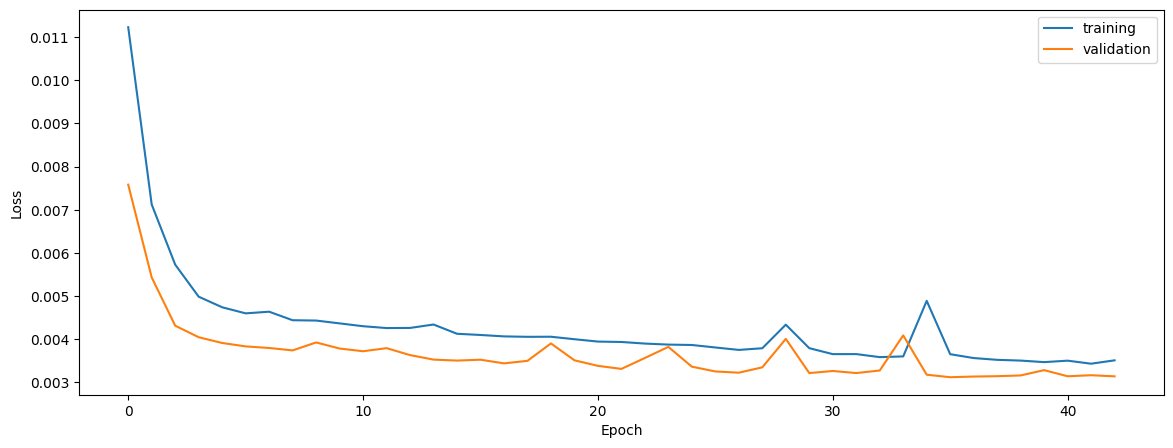

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7817307128744134
0.7987818001344946
0.7899277697376816


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7817307128744134
0.7987818001344946
0.7899277697376816


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7792370112732101
0.8002543122895903
0.7852488905951196


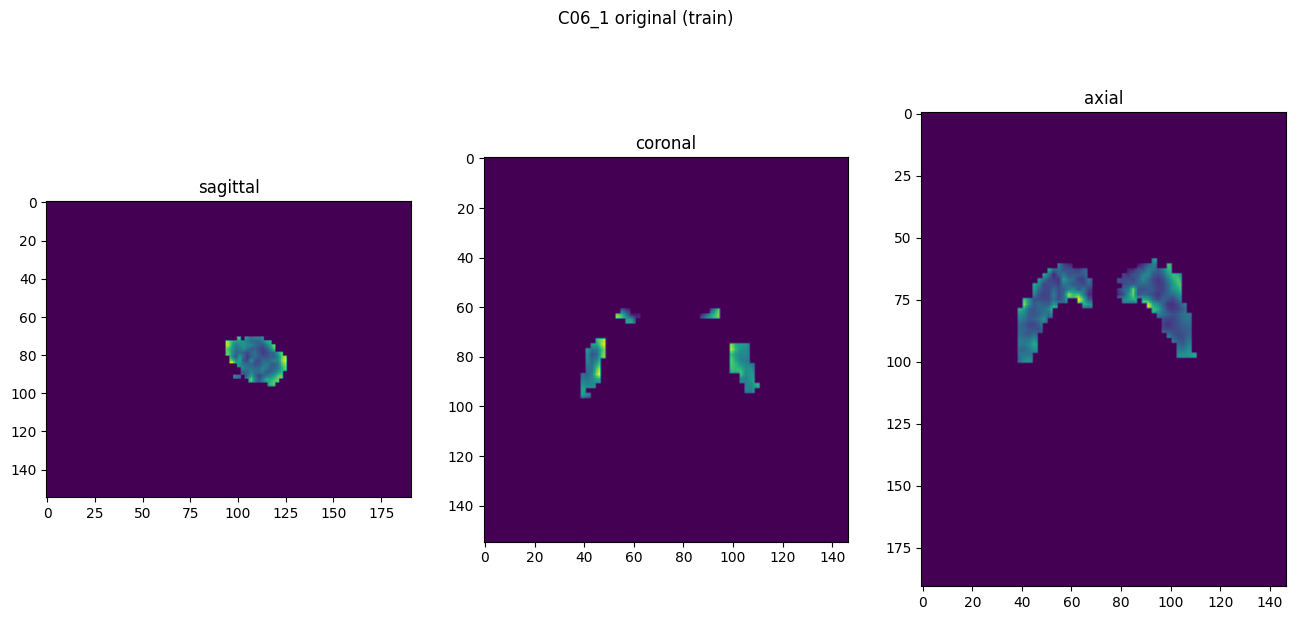

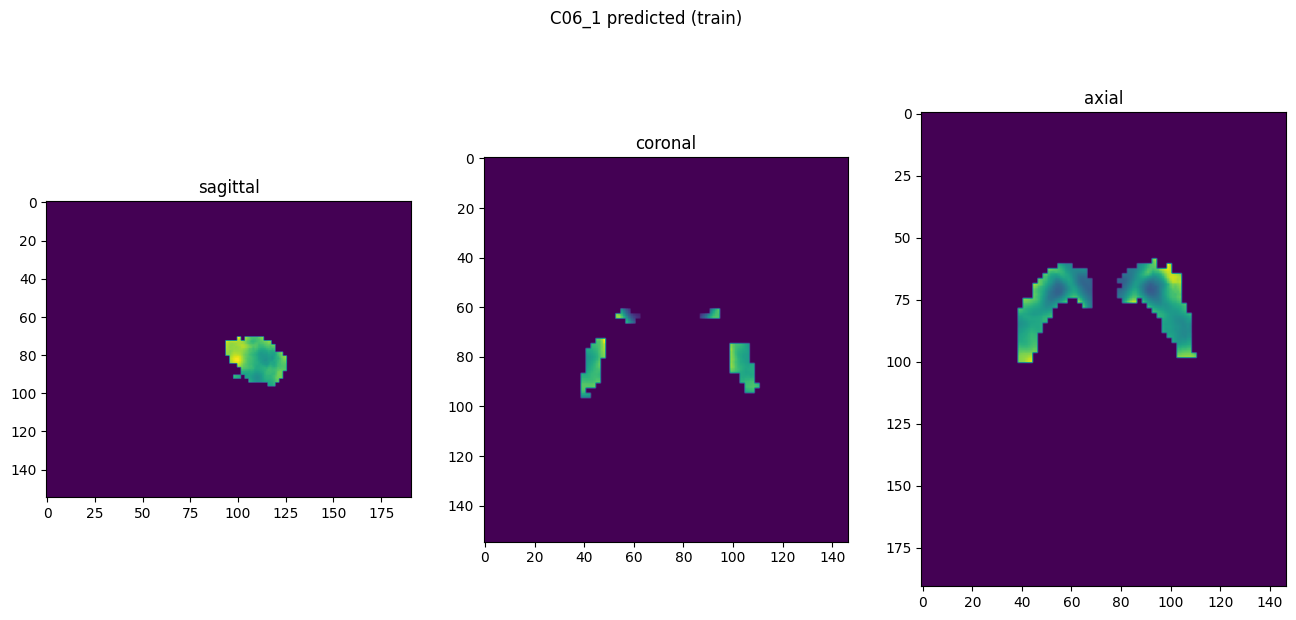

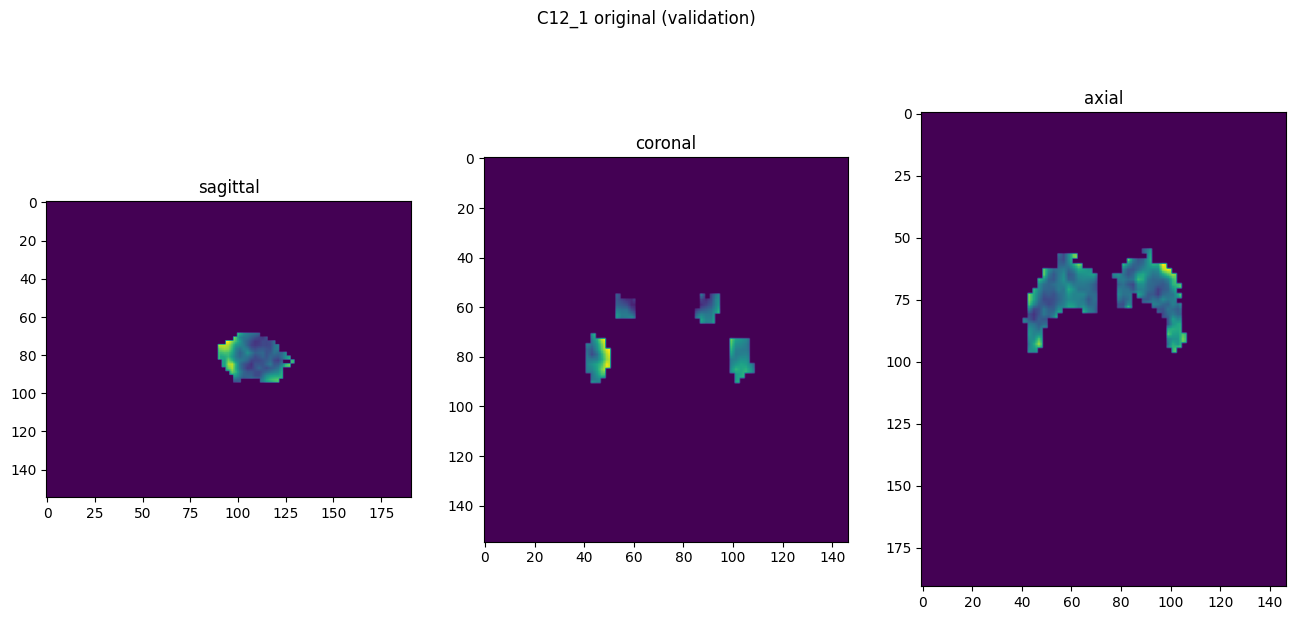

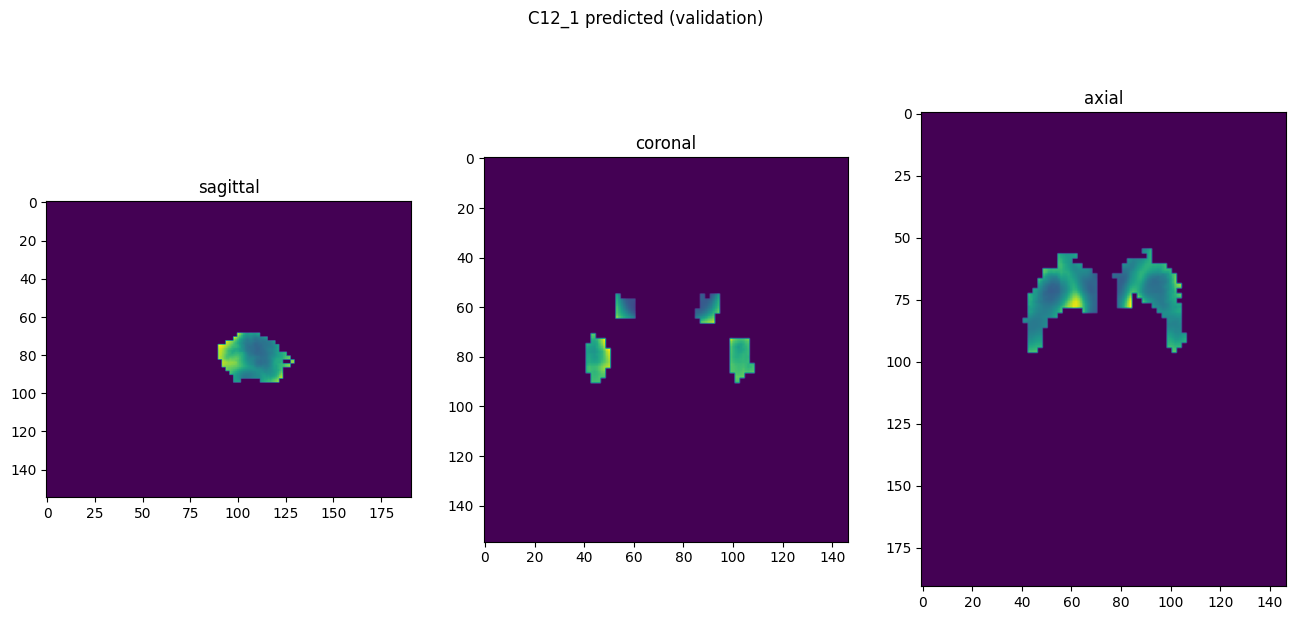

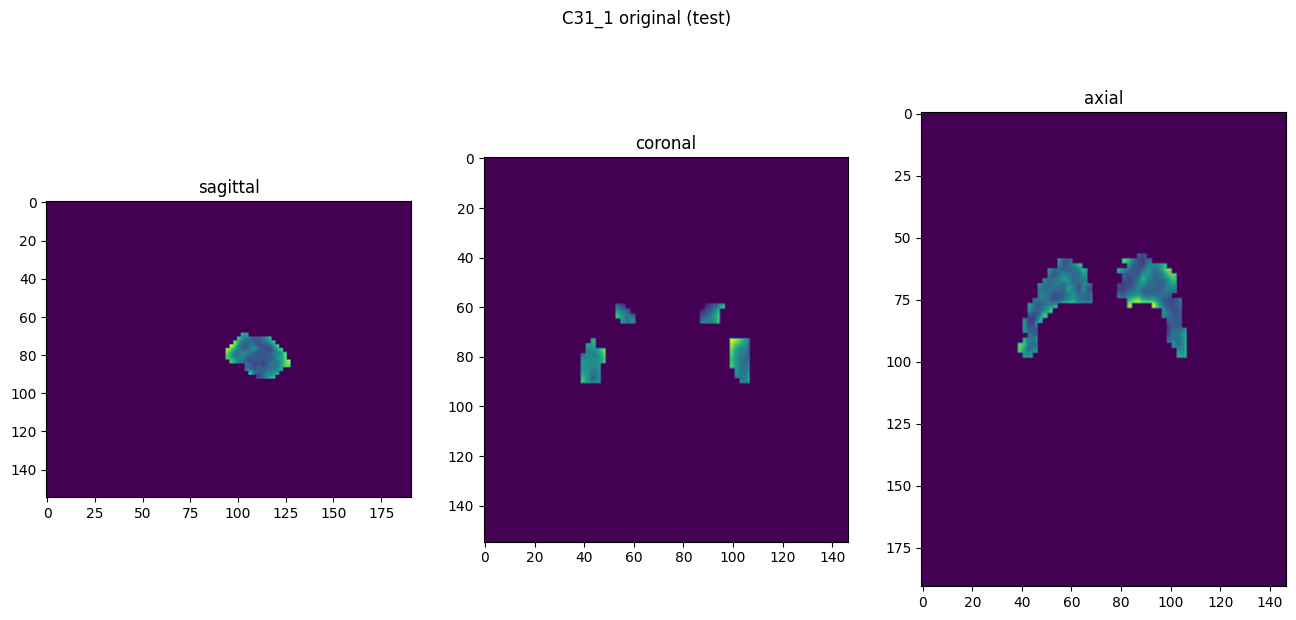

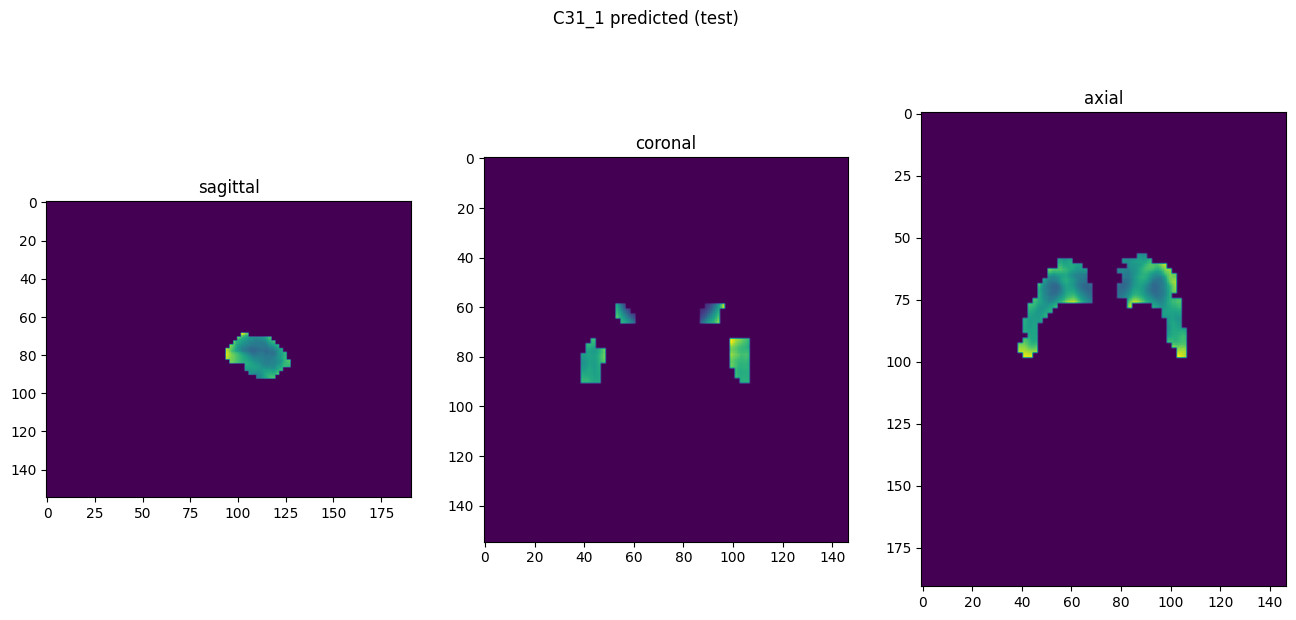

In [10]:
showResults(model, gen, threshold=None, background=False)